[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmickevicius/mcwBiophysicsMriCourse/blob/main/shimming_hw.ipynb)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(1234)

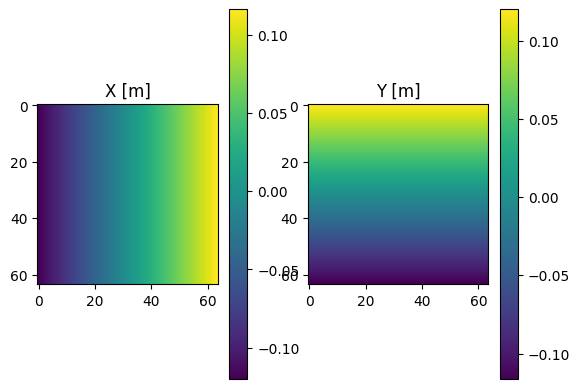

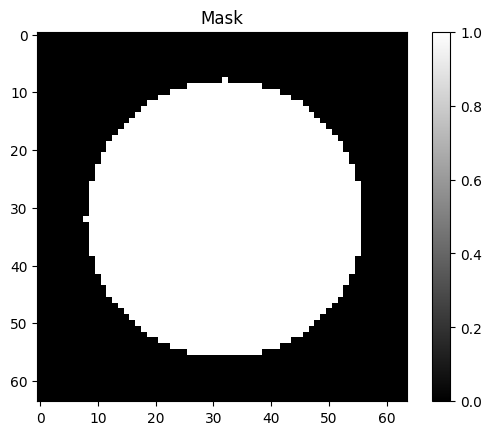

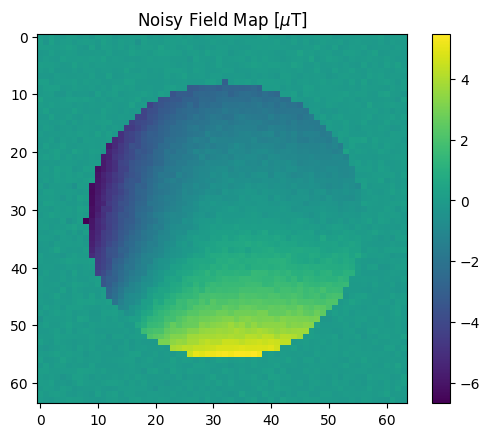

In [4]:
fov = 0.24   # field of view [m]
N = 64       # imaging matrix size 
D = 0.75*fov # diameter of circle phantom
R = D/2      # radius of cicle phantom 

# create 2D arrays of X and Y coordinates 
xv = np.arange(-fov/2, fov/2, fov/N)
yv = np.arange(-fov/2, fov/2, fov/N)
X,Y = np.meshgrid(xv, -yv, indexing='xy')

fig = plt.figure()
fig.add_subplot(121)
plt.imshow(X)
plt.title('X [m]')
plt.colorbar()

fig.add_subplot(122)
plt.imshow(Y)
plt.title('Y [m]')
plt.colorbar()
plt.show()

# make a mask of where we have signal (i.e., inside of a phantom)
mask = np.zeros((N,N), dtype=np.float32)
rad = np.sqrt(X*X + Y*Y)
mask[rad < R] = 1.0

fig = plt.figure()
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.colorbar()

# make a crazy B0 distribution
cx = 1.2e-5
cy = -2.5e-5
cxx = -4.1e-4
cyy = 1.7e-4
cxxx = 3.0e-3
cyyy = -2.8e-3

B0 = cx*X + \
    cy*Y + \
    cxx*X*X + \
    cyy*Y*Y + \
    cxxx*X*X*X + \
    cyyy*Y*Y*Y 

B0 = B0 * mask

noiseLevel = 5/42.58e06 # 5 Hz standard deviation
B0 = B0 + noiseLevel*np.random.randn(N,N)

plt.figure()
plt.imshow(B0*1e6)
plt.title('Noisy Field Map [$\mu$T]')
plt.colorbar()
plt.show()

# get 1d arrays of x value, y value, and noisy field map value in each pixel inside mask
x = X[mask > 0]
y = Y[mask > 0]
b = B0[mask > 0]

data = np.stack([x,y,b],-1)
np.savetxt('shimmingData.csv', data, delimiter=',')



# Homework Problem

Assume we have four coils available to adjust $B_0$ as a function of $x$ and $y$. Two coils change the field linearly as a function of $x$ and $y$ with units of T/m while the other two change field quadratically as a function of $x^2$ and $y^2$ with units of T/m/m. 

Calculate the amplitudes of these first and second order magnetic field gradients that best approximate the noisy, "measured" field map within the phantom. You only need the variables 'x', 'y', and 'b' to do so. You can do this here using python or use the provided csv file and your data science tool of choice. I will note that this can be done with two lines of python :-) 




[ 2.39177565e-05 -3.61743311e-05 -4.08528382e-04  1.69814663e-04]


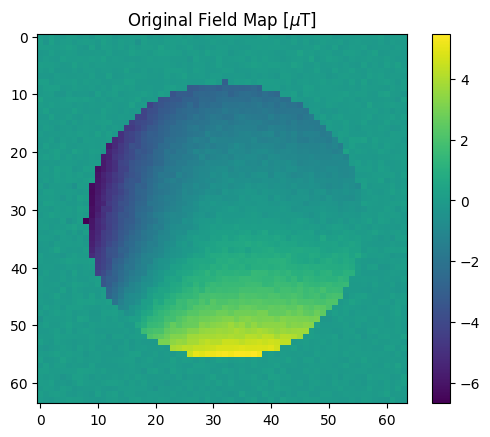

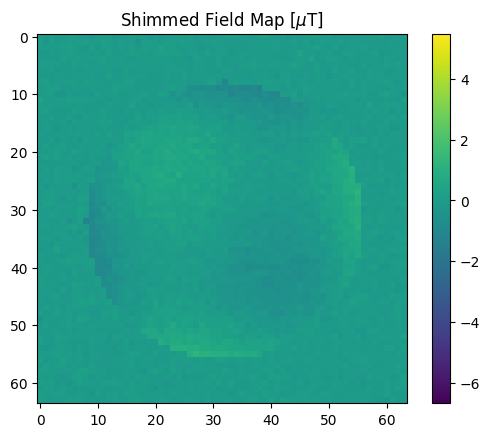

In [6]:
# calculate or type in your solution here to check your results 
# the variable 'solution' should be a numpy array or list with 4 numbers
# these numbers should be the x, y, x*x, and y*y gradient amplitudes
A = np.stack([x, y, x*x, y*y], axis=-1)
solution = np.linalg.inv(A.T @ A) @ (A.T @ b)
print(solution)

predicted_B0 = solution[0]*X + solution[1]*Y + solution[2]*X*X + solution[3]*Y*Y

shimmed = B0 - predicted_B0*mask

plt.figure()
plt.imshow(B0*1e6)
plt.title('Original Field Map [$\mu$T]')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(shimmed*1e6,vmin=np.min(B0)*1e6, vmax=np.max(B0)*1e6)
plt.title('Shimmed Field Map [$\mu$T]')
plt.colorbar()
plt.show()

